In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

2025-05-11 23:36:01.419309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 23:36:01.483363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 23:36:01.547688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746995761.607568    9875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746995761.623516    9875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 23:36:01.738400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Load Data

In [3]:
path = kagglehub.dataset_download("kwentar/blur-dataset")
print("Path:", path)

Path: /home/tariq/.cache/kagglehub/datasets/kwentar/blur-dataset/versions/2


In [4]:
dataset_dir = '/home/tariq/.cache/kagglehub/datasets/kwentar/blur-dataset/versions/2' 
print(os.listdir(dataset_dir)) 

['motion_blurred', 'sharp', 'defocused_blurred', 'blur_dataset_scaled']


## Dataset Preparation

In [5]:
blurred_images_dir = os.path.join(dataset_dir, 'defocused_blurred')  
sharp_images_dir = os.path.join(dataset_dir, 'sharp')

blurred_images = [os.path.join(blurred_images_dir, f) for f in os.listdir(blurred_images_dir)]
sharp_images = [os.path.join(sharp_images_dir, f) for f in os.listdir(sharp_images_dir)]

# Labels: 1 for sharp, 0 for blurred
image_paths = blurred_images + sharp_images
labels = [0] * len(blurred_images) + [1] * len(sharp_images)

# Split
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

## Preprocess the Images

In [6]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0  # Normalize 
    return img_normalized

# Preprocess training and testing images
X_train_processed = np.array([preprocess_image(img) for img in X_train])
X_test_processed = np.array([preprocess_image(img) for img in X_test])

# Reshape 
X_train_processed = np.expand_dims(X_train_processed, axis=-1)#(560, 128, 128, 1)
X_test_processed = np.expand_dims(X_test_processed, axis=-1)

y_train = np.array(y_train)
y_test = np.array(y_test)

## Build the CNN Model

In [7]:
model = models.Sequential([
    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output for the fully connected layer
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification (blurred vs sharp)
])

model.summary()

/home/tariq/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-11 23:36:16.038406: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

## Compile And Train

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train_processed, y_train, epochs=10, batch_size=32, validation_data=(X_test_processed, y_test))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.5147 - loss: 0.8110 - val_accuracy: 0.4357 - val_loss: 0.7351
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.5793 - loss: 0.6697 - val_accuracy: 0.7500 - val_loss: 0.5503
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.7480 - loss: 0.5500 - val_accuracy: 0.8071 - val_loss: 0.4734
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.7859 - loss: 0.4835 - val_accuracy: 0.8857 - val_loss: 0.2904
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.8559 - loss: 0.3460 - val_accuracy: 0.9071 - val_loss: 0.2535
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.8469 - loss: 0.3598 - val_accuracy: 0.9286 - val_loss: 0.2502
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.8971 - loss: 0.2840 - val_accuracy: 0.9143 - val_loss: 0.2135
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9173 - loss: 0.2494 - val_accuracy: 0.

## Evaluation

In [9]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save
model.save('blur_vs_sharp_model.h5')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9547 - loss: 0.2085


Test Accuracy: 95.00%


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


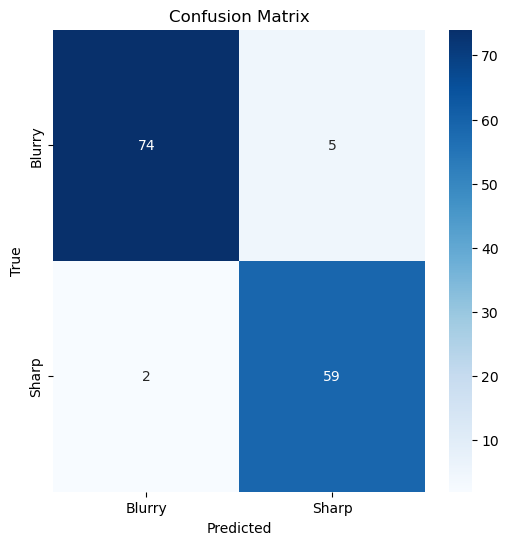

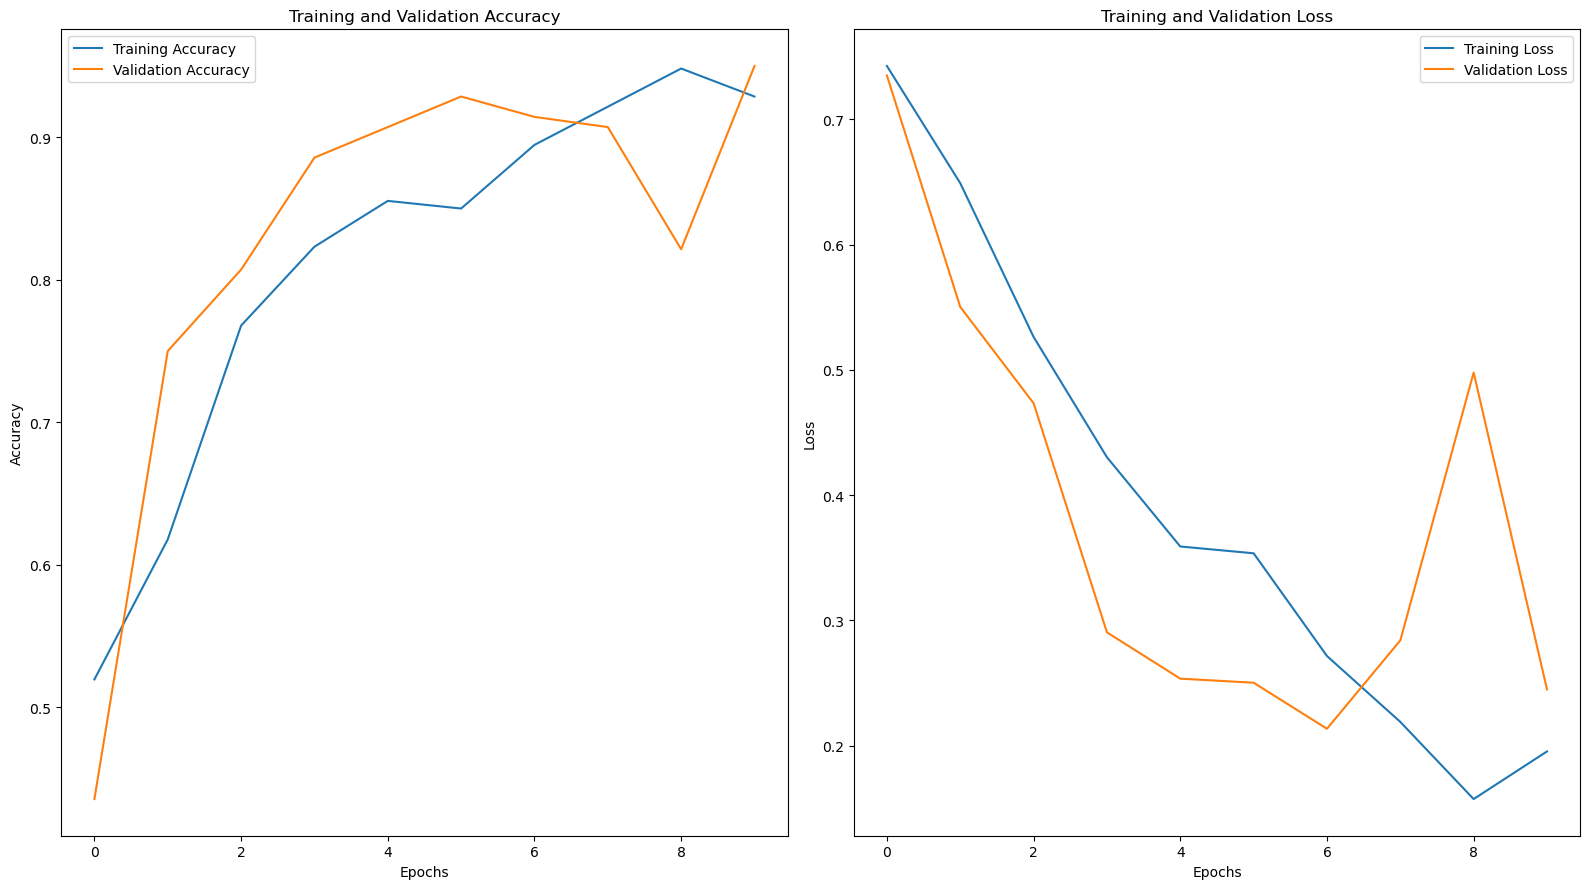

In [13]:
y_pred = model.predict(X_test_processed)
y_pred = (y_pred > 0.5)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Blurry", "Sharp"], yticklabels=["Blurry", "Sharp"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Training & Validation Accuracy
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F-score
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        79
           1       0.92      0.97      0.94        61

    accuracy                           0.95       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.95      0.95      0.95       140



## Test with real life example

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


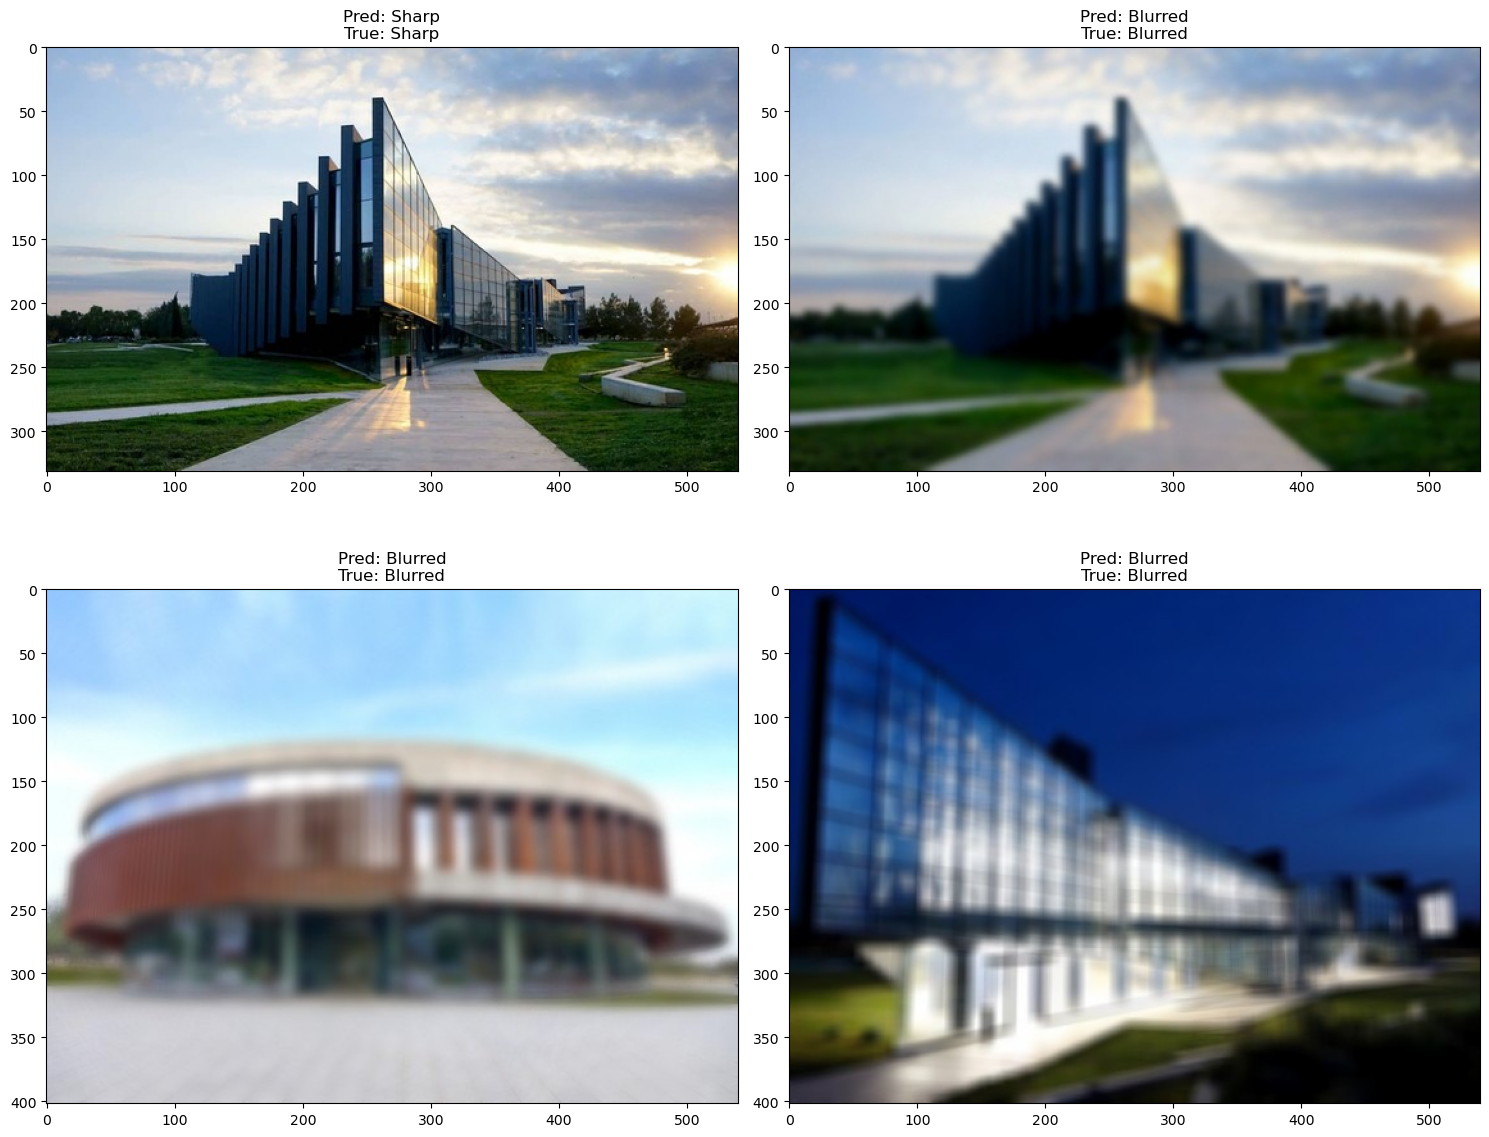

In [12]:
def classify_and_display_images(image_paths, model, true_labels=None):
    images = np.array([preprocess_image(image_path) for image_path in image_paths])
    images = np.expand_dims(images, axis=-1)

    predictions = model.predict(images)
    predictions = (predictions > 0.5).astype(int) 

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = cv2.imread(image_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        #title
        label = "Sharp" if predictions[i] == 1 else "Blurred"
        true_label = "Sharp" if true_labels[i] == 1 else "Blurred" if true_labels is not None else "Unknown"
        ax.set_title(f"Pred: {label}\nTrue: {true_label}", fontsize=12)
   
    plt.tight_layout()
    plt.show()

image_paths = ["r1.jpg","b2.jpg","b1.jpg","b3.jpg"]
true_labels = [1, 0, 0, 0] 

classify_and_display_images(image_paths, model, true_labels)